In [13]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan
from collections import Counter

In [2]:
k_neighbors = 100
evecs=50

In [3]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

# D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
# D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.931606   0.88671194 0.87572654 0.86935432 0.84942745 0.84172481
 0.83594643 0.82809586 0.82357771 0.82029732 0.80912259 0.79816157
 0.79135036 0.78178592 0.78052719 0.77495363 0.76503256 0.74307414
 0.73856154 0.73550597 0.72744548 0.72669242 0.72338311 0.70576218
 0.70333528 0.70079346 0.69153401 0.68824966 0.68793044 0.68677967
 0.6808395  0.68013388 0.67247398 0.67115741 0.66565417 0.6549933
 0.65087081 0.63994229 0.63139768 0.62906463 0.61814475 0.6134812
 0.60973951 0.60626703 0.60581677 0.60359569 0.59473904 0.59430699
 0.59056195 0.58767297]


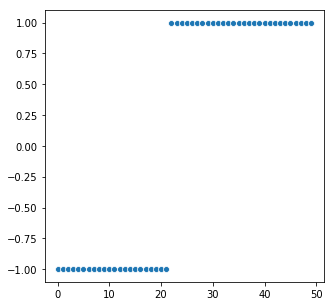

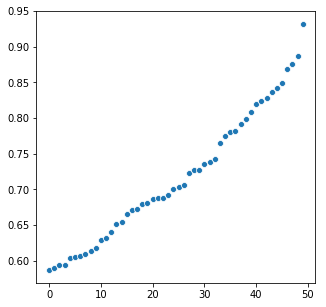

In [4]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [5]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

L_evecdf = get_evec_df(L_evecs, top_k_evecs=10)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=10)

In [6]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  44083.000000  44083.000000  44083.000000  44083.000000  44083.000000   
mean      -0.000587      0.000367      0.001206     -0.000840     -0.000981   
std        0.004727      0.004749      0.004608      0.004688      0.004661   
min       -0.186532     -0.281086     -0.342671     -0.299141     -0.286647   
25%       -0.000704      0.000214      0.000624     -0.000991     -0.001220   
50%       -0.000469      0.000325      0.000948     -0.000660     -0.000813   
75%       -0.000309      0.000489      0.001423     -0.000435     -0.000535   
max        0.428433      0.306733      0.210876      0.386752      0.413290   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  
count  44083.000000  44083.000000  44083.000000  44083.000000  44083.000000  
mean       0.000057      0.000086      0.000405     -0.000112      0.000831  
std        0.004763      0.004762      0.004746      0

In [8]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=5
drop_k_evecs=1
Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(44083, 5) (44083, 5)


In [9]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

Error: 1 or more umap files not found


./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)
./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


running Kmeans


/data1/andrew/anaconda2/envs/mengp369/lib/python3.6/site-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (45) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  if __name__ == '__main__':


Cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 41 44 45 46 48 49]


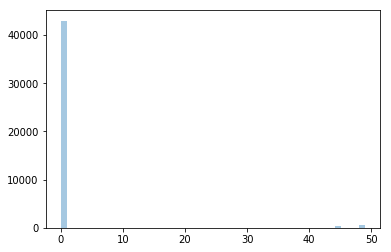

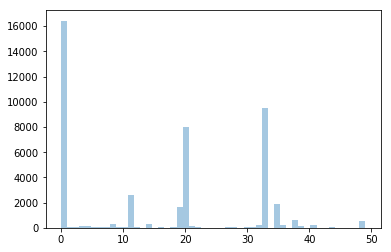

In [10]:
knn_clusters = 50

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

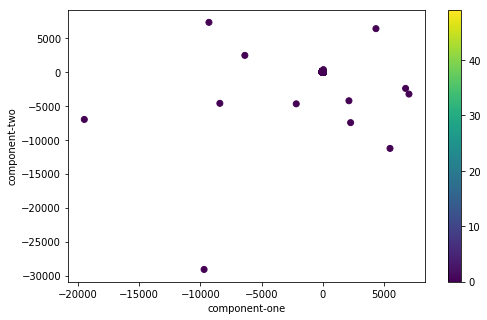

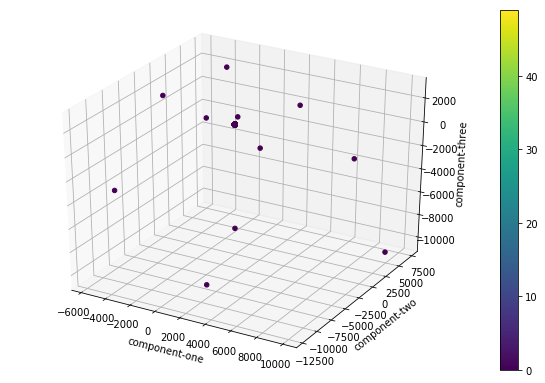

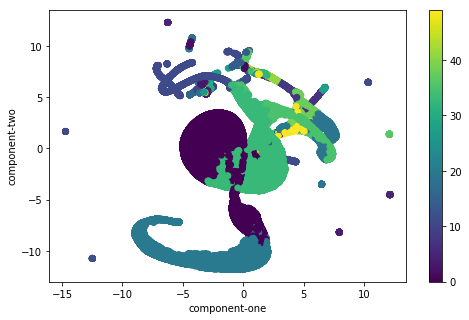

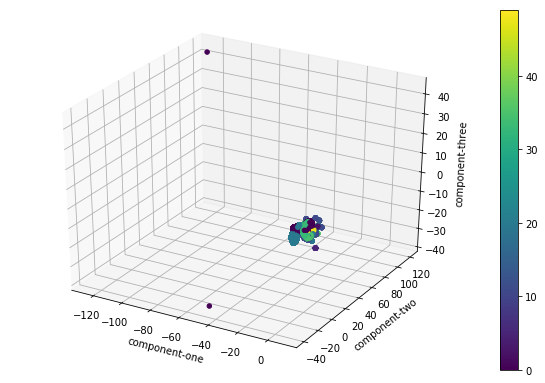

In [11]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

In [30]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

def sort_by_top_k_cluster_membership(M, k, cluster_labels, exclude=2):    
    
    top_cluster_and_counts = Counter(cluster_labels).most_common(k + exclude)
    print(top_cluster_and_counts)
    top_cluster_and_counts = top_cluster_and_counts[exclude:]
    print("...".format(exclude), top_cluster_and_counts)
    most_common_clusters = [c[0] for c in top_cluster_and_counts]

    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    
    sorted_cluster_labels_filtered = [p for p in sorted_cluster_labels if p[1] in most_common_clusters]
    clusters_by_idx = [p[0] for p in sorted_cluster_labels_filtered]
    return M[clusters_by_idx][:, clusters_by_idx]
    
L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

topk_clusters = 4
exclude_topk = 2
A_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_cluster_labels, exclude_topk)
L_sorted_topk = sort_by_top_k_cluster_membership(L, topk_clusters, Y_cluster_labels, exclude_topk)

A_mc_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_mc_cluster_labels, exclude_topk)
L_mc_sorted_topk = sort_by_top_k_cluster_membership(L_mc, topk_clusters, Y_mc_cluster_labels, exclude_topk)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)
print(L_sorted_topk.shape, A_sorted_topk.shape, L_mc_sorted_topk.shape, A_mc_sorted_topk.shape)

[(0, 42959), (49, 636), (45, 397), (48, 9), (46, 7), (3, 5)]
... [(45, 397), (48, 9), (46, 7), (3, 5)]
[(0, 42959), (49, 636), (45, 397), (48, 9), (46, 7), (3, 5)]
... [(45, 397), (48, 9), (46, 7), (3, 5)]
[(0, 16430), (33, 9469), (20, 8022), (11, 2599), (35, 1925), (19, 1641)]
... [(20, 8022), (11, 2599), (35, 1925), (19, 1641)]
[(0, 16430), (33, 9469), (20, 8022), (11, 2599), (35, 1925), (19, 1641)]
... [(20, 8022), (11, 2599), (35, 1925), (19, 1641)]
(44083, 44083) (44083, 44083) (44083, 44083) (44083, 44083)
(418, 418) (418, 418) (14187, 14187) (14187, 14187)


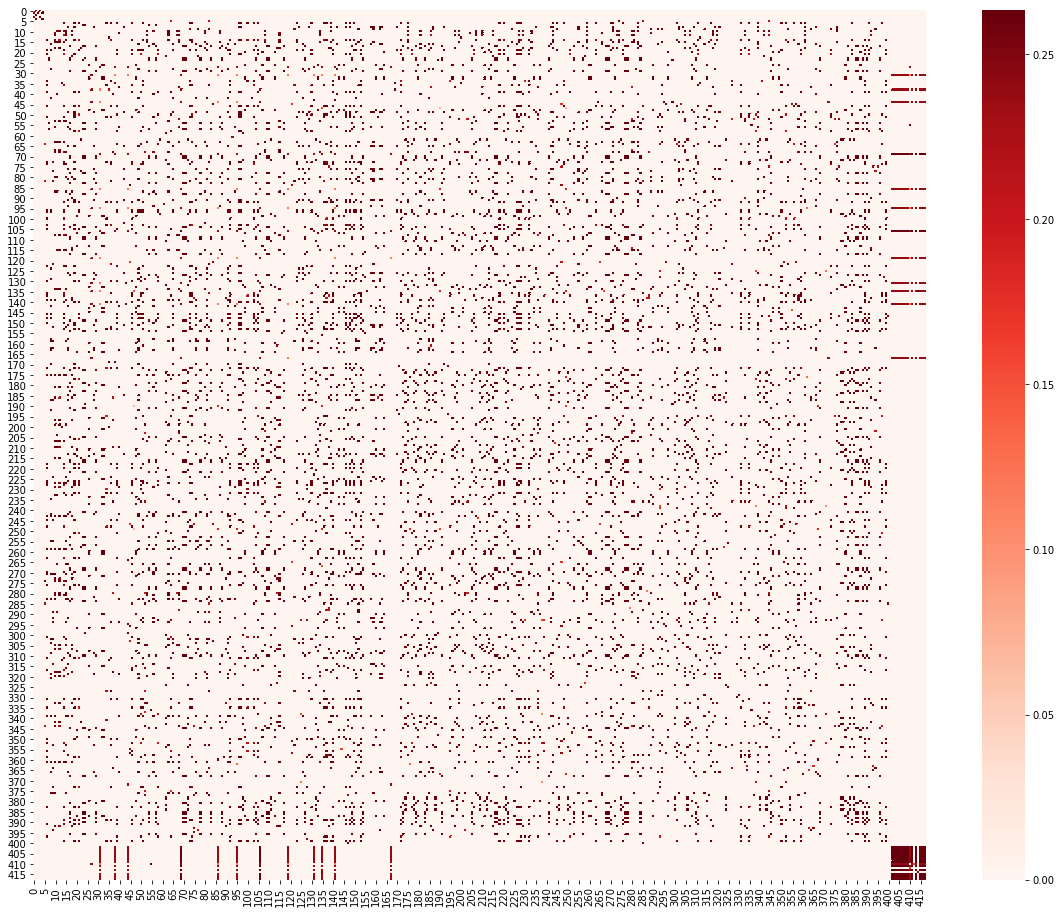

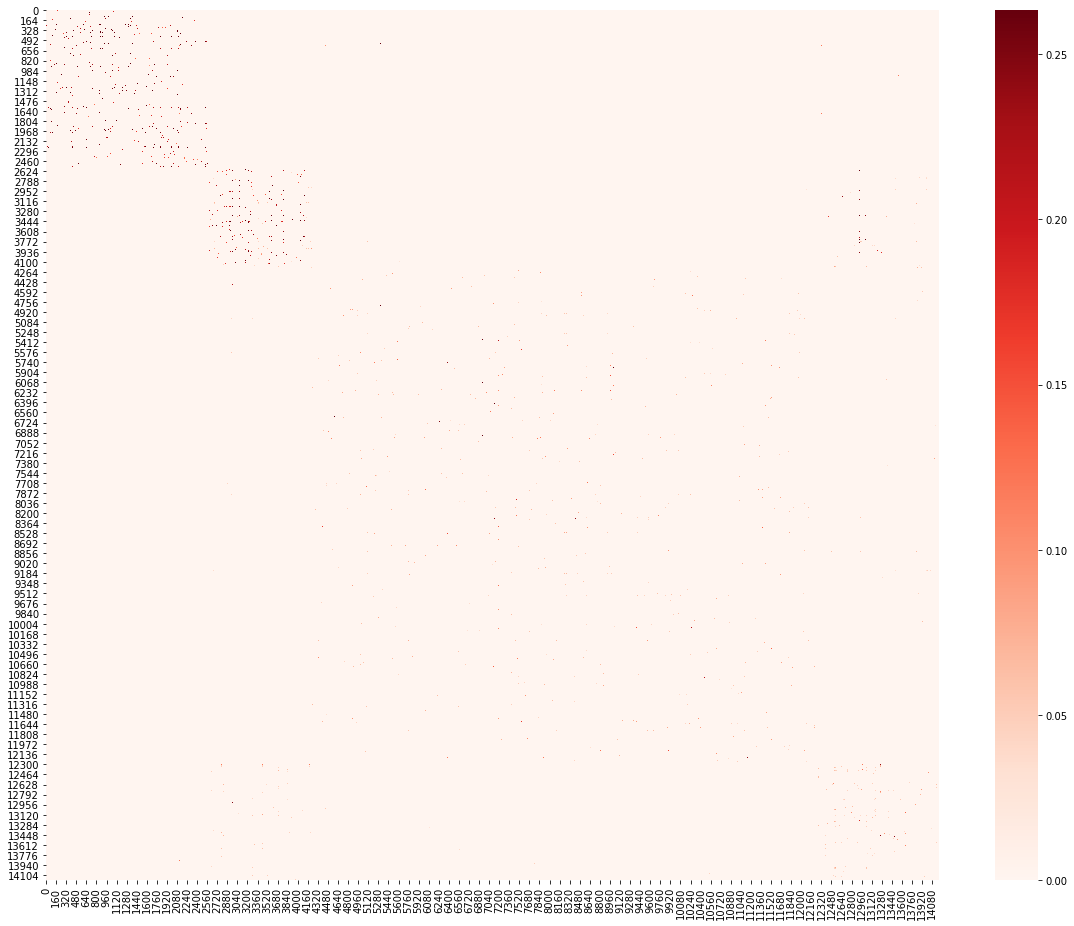

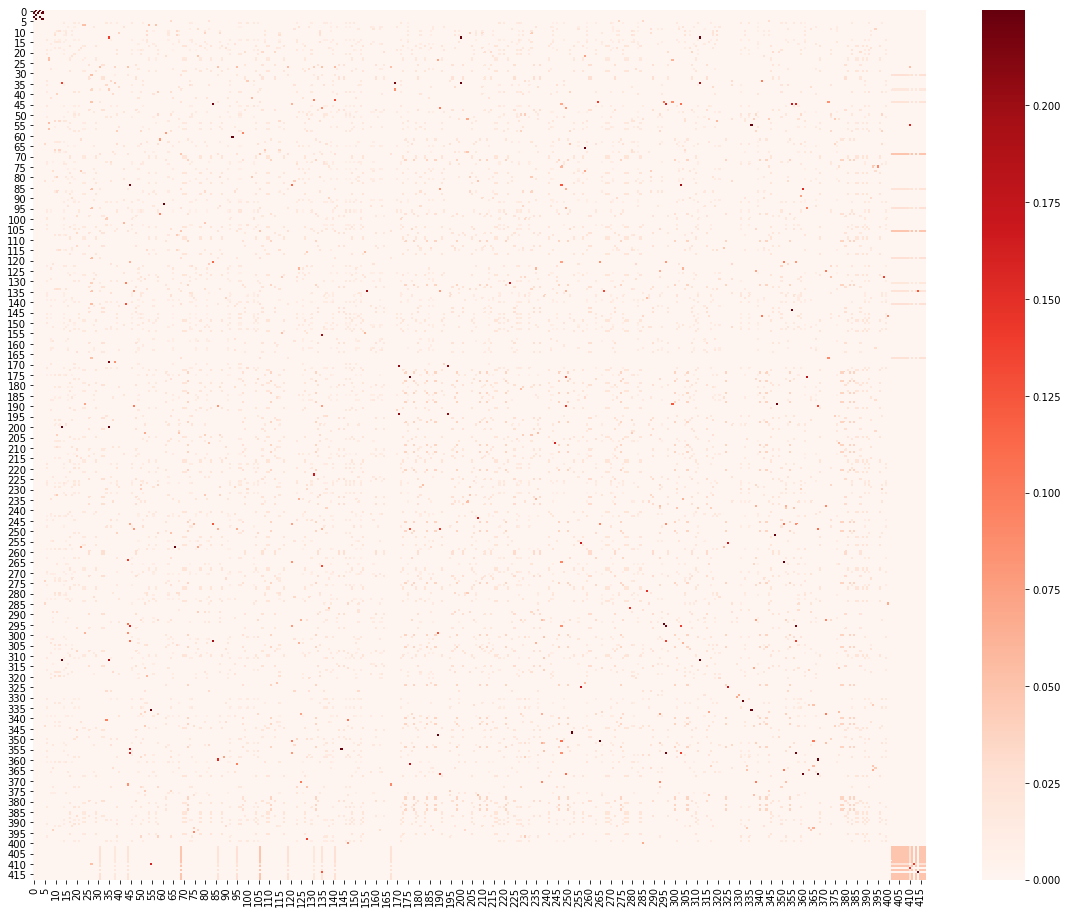

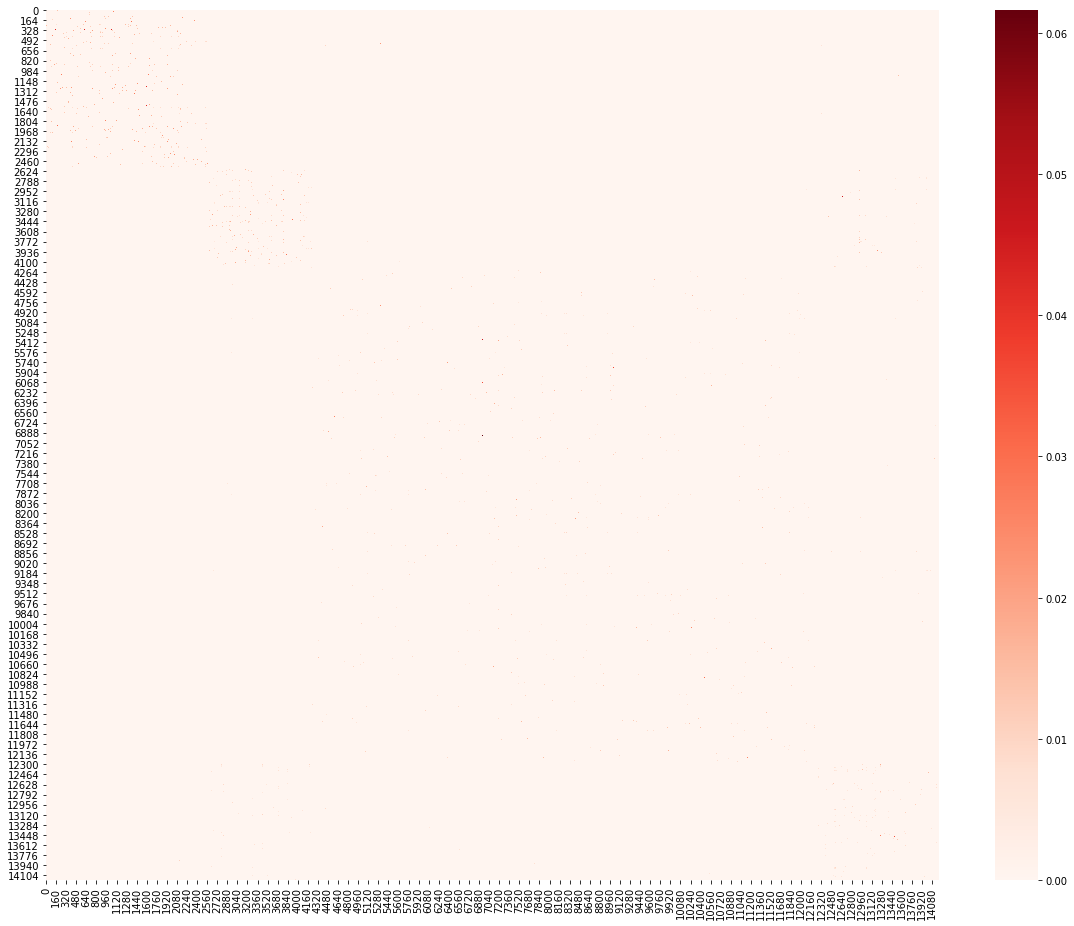

In [31]:
##Full Heatmaps
plot_vars = [A_sorted_topk, A_mc_sorted_topk, L_sorted_topk, L_mc_sorted_topk]
plot_var_names = ['A_sorted_topk', 'A_mc_sorted_topk', 'L_sorted_topk', 'L_mc_sorted_topk']
for v in range(len(plot_vars)):
    var = plot_vars[v]
    varname = plot_var_names[v]

    plotmax = var.log1p().log1p().max()/2.0
    plt.figure(figsize=(20,16))
    sns.heatmap(var.log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
    plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs))